# PyTorch_Tutorial_4 : TRAINING A CLASSIFIER

### 이 노트는 아래의 웹사이트의 코드를 따라가며 해설하였다.

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

## What about data?

#### NOTE ) 표준 파이썬 패키지들을 이용하면 이미지, 텍스트, 오디오, 혹은 비디오와 같은 데이터들을 numpy 배열로 받아볼 수 있다.

- For images, packages such as Pillow, OpenCV are useful
- For audio, packages such as scipy and librosa
- For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

## Training an image classifier

- Load and normalizing the CIFAR10 training and test datasets using torchvision
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

In [1]:
import time
from pprint import pprint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

### 1. Loading and normalizing CIFAR10

- torchvision.datasets 을 통해 여러 종류의 데이터를 다운로드할 수 있고, torch.utils.data.DataLoader 를 통해 데이터 형태를 변환한다.

In [2]:
# If running on Windows and you get a BrokenPipeError,
# try setting the num_worker of torch.utils.data.DataLoader() to 0.

# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))
                               ])

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# 데이터갯수 확인
print(len(trainset), len(testset))

50000 10000


In [4]:
# 미니배치갯수 확인
print(len(trainloader), len(testloader))

12500 2500


In [5]:
# 하나의 이미지텐서의 형태 확인
trainset[0][0].size()

torch.Size([3, 32, 32])

In [6]:
for i,j in enumerate(trainloader):
    if i > 0: break
    print(j[0].size())
    print(j[1])

torch.Size([4, 3, 32, 32])
tensor([8, 1, 7, 3])


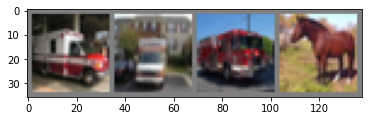

      truck       truck       truck       horse


In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%11s' % classes[labels[j]] for j in range(4)))

### 2. Define a Convolutional Neural Network

In [8]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 6 input image channel, 16 output channels, 5x5 square convolution
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)  # 여기서는 F.max_pool2d 대신에 nn.MaxPool2d를 이용했다.
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

In [10]:
start_time = time.time()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2500 == 2499:    # print every 2500 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2500))
            running_loss = 0.0

end_time = time.time()
print('Finished Training')
print('Time duration :', end_time - start_time, "sec")

[1,  2500] loss: 2.149
[1,  5000] loss: 1.770
[1,  7500] loss: 1.623
[1, 10000] loss: 1.538
[1, 12500] loss: 1.484
[2,  2500] loss: 1.407
[2,  5000] loss: 1.372
[2,  7500] loss: 1.320
[2, 10000] loss: 1.315
[2, 12500] loss: 1.264
Finished Training
Time duration : 100.52413487434387 sec


In [11]:
# Save the result
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. TEST

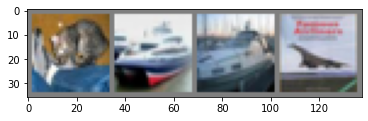

GroundTruth:    cat  ship  ship plane


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
# Reload the saved parameters
net=Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
outputs = net(images)
print(outputs)

tensor([[-0.8272, -3.1096,  0.6959,  1.8871, -1.3816,  0.8079,  0.8883, -0.5079,
         -0.4992,  0.4548],
        [ 4.4297,  6.2219, -1.3041, -3.2438, -4.6089, -4.7068, -3.4086, -4.6637,
          6.8721,  3.4516],
        [ 1.9589,  3.7518, -0.7340, -1.5017, -2.9840, -2.4176, -2.6559, -2.3443,
          2.9701,  2.5390],
        [ 5.6743,  1.5594, -0.0258, -2.5604, -1.1811, -4.8353, -2.8370, -3.8995,
          5.0695,  1.7565]], grad_fn=<AddmmBackward>)


In [15]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship   car plane


In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


#### what are the classes that performed well, and the classes that did not perform well? 

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()  # True is interpreted as 1, False as 0.
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 64 %
Accuracy of   car : 62 %
Accuracy of  bird : 34 %
Accuracy of   cat : 48 %
Accuracy of  deer : 29 %
Accuracy of   dog : 32 %
Accuracy of  frog : 68 %
Accuracy of horse : 71 %
Accuracy of  ship : 63 %
Accuracy of truck : 70 %


## Training on GPU

- Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [19]:
# Let's check how much the time duration be shorter than CPU version.

net = Net()

################################################################################################################
# These methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors. #
################################################################################################################
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

start_time = time.time()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        ############################################################################################
        # Remember that you will have to send the inputs and targets at every step to the GPU too. #
        ############################################################################################
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2500 == 2499:    # print every 2500 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2500))
            running_loss = 0.0

end_time = time.time()
print('Finished Training')
print('Time duration :', end_time - start_time, "sec")

[1,  2500] loss: 2.150
[1,  5000] loss: 1.797
[1,  7500] loss: 1.599
[1, 10000] loss: 1.500
[1, 12500] loss: 1.421
[2,  2500] loss: 1.372
[2,  5000] loss: 1.356
[2,  7500] loss: 1.299
[2, 10000] loss: 1.287
[2, 12500] loss: 1.264
Finished Training
Time duration : 108.19362187385559 sec


#### NOTE ) GPU seems to be slower than the CPU, but that's because the time of transferring data to GPU exceeds the decrement of training time. Only focusing on the training time itself will show obvious advantage of using GPU, and this becomes more and more clear when the neural net gets larger and more complicate.